# Python trading bot

## ( with backtesting strategies and indicators)

## import section

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
%matplotlib inline


In [2]:
df = pd.read_excel('table.xlsx', index=True)
df.columns = ["Date", 'Open', 'High', 'Low', 'Close', 'Volume', "market_cap"]

df = df.reindex(index=df.index[::-1])

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.iloc[:, :5]
close_prices = df['Close']



## compute RSI

In [3]:
# rsi_list = []
# deltas = np.diff(close_prices)
# n = 14
# seed = deltas[:n+1]
# up = seed[seed>=0].sum()/n
# down= -seed[seed<0].sum()/n
# rs  =up/ down
# rsi = np.zeros_like(close_prices)
# rsi[:n] = 100. -100./(1.+rs)
# for i in range(n, len(close_prices)):
#     delta = deltas[i-1]
#     if delta > 0:
#         upval = delta
#         downval =  0.
#     else:
#         upval = 0.
#         downval = -delta
    
#     up = (up*(n-1)+ upval)/n
#     down = (down*(n-1) + downval)/n
#     rs =  up/down
#     rsi[i] = 100. - 100./(1.+rs)
#     rsi_list.append(rsi[i])

## COMPUTE MACD

MACD is a famous trading indicator. it means: Moving Averages Convergence/Divergence. It consists of comparing the value of the 12 periods (here daily) exponential moving average (EMA) with the 26 periods EMA. It is used to detect entry point to buy or sell an asset. Moreover, it's a good indicator of the momentum of a price action. MACD is one of the most robust strategy to use to be profitable.



In [4]:
exp12 = close_prices.ewm(span=12, adjust=False).mean()
exp26 = close_prices.ewm(span=26, adjust=False).mean()
macd = exp12 - exp26

signal    = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal


apds = [
        mpf.make_addplot(histogram,type='bar',width=0.7,panel=1,
                         color='dimgray',alpha=1,secondary_y=False),
        mpf.make_addplot(macd,panel=1,secondary_y=True),
        mpf.make_addplot(signal,panel=1,color='orange',secondary_y=True),
       ]

## ploting the data with MACD strategy 

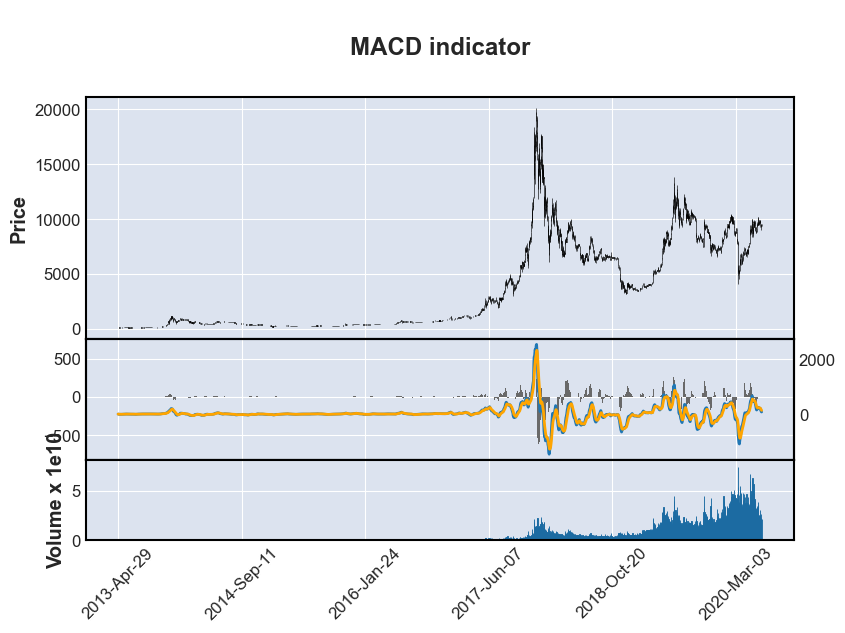

In [5]:
mpf.plot(df,type='candle',addplot=apds,figscale=1.1,figratio=(8,5),title='\nMACD indicator',
         volume=True,volume_panel=2,panel_ratios=(6,3,2))
plt.show()


now that you know what MACD is and looks like, i propose you to backtest this indicator with all the data available to see the performance of it.

we will use these simple rules:
BUY when the MACD line (blue) crosses over the signal line (orange) and if they have negative values.
SELL when the MACD line crosses below the signal line and if they have positive values.

I will display the result of each trade in a DataFrame for analysis.


## backtesting section of the MACD strategy

In [6]:


cursor = 1
buy_sell_list = []

while cursor < len(df) - 1:
    try:
        while np.sign(histogram.iloc[cursor]) == -1 and signal.iloc[cursor] < 0:
            cursor += 1

        buy_sell_list.append(f"buy at {close_prices.iloc[cursor]}")

        while signal.iloc[cursor] < 0:
            cursor += 1

        while np.sign(histogram.iloc[cursor]) == 1: 
            cursor += 1 

        buy_sell_list.append(f"sell at {close_prices.iloc[cursor]}")

        while signal.iloc[cursor] > 0: 
            cursor += 1
            
    except IndexError:
        break
        
print("this is the list of all buy/sell actions that would have been made with the MACD strategy and our set of conditions\n \n",  buy_sell_list)    

this is the list of all buy/sell actions that would have been made with the MACD strategy and our set of conditions
 
 ['buy at 117.98', 'sell at 122.22', 'buy at 108.25', 'sell at 103.0', 'buy at 745.05', 'sell at 860.9', 'buy at 578.77', 'sell at 653.15', 'buy at 592.58', 'sell at 350.85', 'buy at 320.19', 'sell at 285.51', 'buy at 260.6', 'sell at 233.13', 'buy at 229.71', 'sell at 279.47', 'buy at 229.78', 'sell at 336.82', 'buy at 389.59', 'sell at 421.65', 'buy at 585.59', 'sell at 605.98', 'buy at 921.79', 'sell at 1004.45', 'buy at 1071.79', 'sell at 2155.8', 'buy at 2817.6', 'sell at 4001.74', 'buy at 3892.35', 'sell at 5526.64', 'buy at 11296.4', 'sell at 9395.01', 'buy at 8879.62', 'sell at 9234.82', 'buy at 7643.45', 'sell at 7624.91', 'buy at 6488.76', 'sell at 6467.07', 'buy at 6734.95', 'sell at 3854.79', 'buy at 10518.17', 'sell at 10051.7', 'buy at 10623.54', 'sell at 8813.58', 'buy at 7321.99', 'sell at 8406.52', 'buy at 6185.07', 'sell at 8601.8']


## Now we are going to display in a DataFrame the wintrade of the strategy as well as the total gain/loss with a starting investment of 100 dollars.

In [7]:
investment = 100
result_df = pd.DataFrame()
result_df['buy'] = [float(item.split(' ')[-1]) for item in buy_sell_list if item.startswith('buy')]
result_df['sell'] = [float(item.split(' ')[-1]) for item in buy_sell_list if item.startswith('sell')]
result_df['gain/loss (%)'] = [(row[1][1]-row[1][0])/row[1][0] for row in result_df.iterrows()]

equity_list = []
for item in range(len(result_df)):
    global investment
    new_investment = investment* (1 + result_df.iloc[item, 2])
    equity_list.append(new_investment)
    investment = new_investment
result_df['equity'] = equity_list

result_df

,buy,sell,gain/loss (%),equity
0,117.98,122.22,0.035938,103.593829
1,108.25,103.00,-0.048499,98.569648
2,745.05,860.90,0.155493,113.896531
3,578.77,653.15,0.128514,128.533820
4,592.58,350.85,-0.407928,76.101270
5,320.19,285.51,-0.108311,67.858689
6,260.60,233.13,-0.105411,60.705665
7,229.71,279.47,0.216621,73.855784
8,229.78,336.82,0.465837,108.260532
9,389.59,421.65,0.082292,117.169469


Here we are! we can see that with a starting 100 dollars investment, we end up with 333 dollars just by following our simple trading rules. This is a 233% profit. Our strategy isn't perfect and in the futur, we will try to improve our MACD strategy to get better results. Moreover, we will compare our MACD strategy with other famous indicators such as RSI (relative strengh index).